In [1]:
import bs4

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys

In [2]:
driver = webdriver.Chrome()

In [3]:
driver.get('https://www.google.com/flights/explore/')

In [4]:
to_input = driver.find_element_by_xpath('//*[@id="root"]/div[3]/div[3]/div/div[4]/div/div')

In [5]:
to_input.click()

In [6]:
actions = ActionChains(driver)
actions.send_keys('South America')
actions.send_keys(Keys.ENTER)
actions.perform()

In [14]:
results = driver.find_elements_by_class_name('LJTSM3-v-d')
test = results[0]
bars = test.find_elements_by_class_name('LJTSM3-w-x')
print len(results)
results[:2]

12


[<selenium.webdriver.remote.webelement.WebElement (session="f3369fded0d7b34c6c8f55ca44f564e5", element="0.9044369644514918-2")>,
 <selenium.webdriver.remote.webelement.WebElement (session="f3369fded0d7b34c6c8f55ca44f564e5", element="0.9044369644514918-3")>]

In [15]:
test.text

u'Best price $245\nNonstop $296\nCura\xe7ao, Cura\xe7ao\n$725\n$245\nMarch\nApril\nMay'

In [16]:
import time
data = []

for bar in bars:
    ActionChains(driver).move_to_element(bar).perform()
    time.sleep(0.001)
    data.append((test.find_element_by_class_name('LJTSM3-w-k').find_elements_by_tag_name('div')[0].text,
           test.find_element_by_class_name('LJTSM3-w-k').find_elements_by_tag_name('div')[1].text))

In [17]:
print data[:5]
data[-5:]

[(u'$247', u'Thu Mar 16 - Tue Mar 21'), (u'$332', u'Fri Mar 17 - Tue Mar 21'), (u'$327', u'Sat Mar 18 - Tue Mar 21'), (u'$327', u'Sun Mar 19 - Wed Mar 22'), (u'$408', u'Mon Mar 20 - Sat Mar 25')]


[(u'$247', u'Wed May 10 - Sat May 13'),
 (u'$306', u'Thu May 11 - Tue May 16'),
 (u'$306', u'Fri May 12 - Tue May 16'),
 (u'$247', u'Sat May 13 - Thu May 18'),
 (u'$247', u'Sun May 14 - Wed May 17')]

In [18]:
import pandas as pd
import datetime
%matplotlib inline
from dateutil.parser import parse
d = data[0]
clean_data = [(float(d[0].replace('$', '').replace(',', '')), (parse(d[1].split('-')[0].strip()) - datetime.datetime(2017,3,13,0,0)).days, reduce(lambda x,y: y-x, [parse(x.strip()) for x in d[1].split('-')]).days) for d in data]

In [19]:
df = pd.DataFrame(clean_data, columns=['Price', 'Start_Date', 'Trip_Length'])

## Exploratory Data Analysis (EDA) is where you should always begin
## As well as where you should spend most of your time, see what's happening in the data. Your brain is better than most ML algorithms (at least for now)

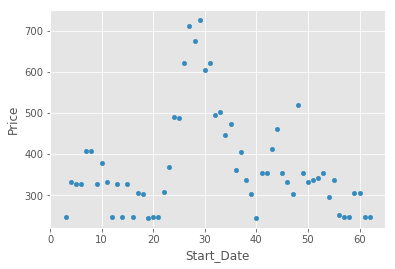

In [20]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

# Pandas has a ton of built-in visualizations
# Play and Learn
# http://pandas.pydata.org/pandas-docs/stable/visualization.html
df.plot.scatter(x='Start_Date', y='Price')

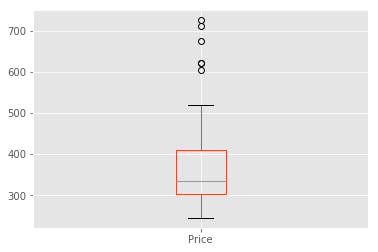

In [21]:
df['Price'].plot.box()

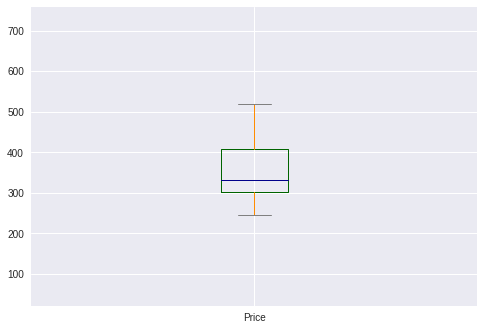

In [26]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
df['Price'].plot.box(color=color, sym='r+')

### Let's see what happens when we manually add an outlier

In [23]:
df = df.set_value(49, 'Price', 55)
# Time for a Google Investigation
# "IQR Outlier"

## Introducing seaborn
### seaborn makes it easy to create some really high quality visualizations

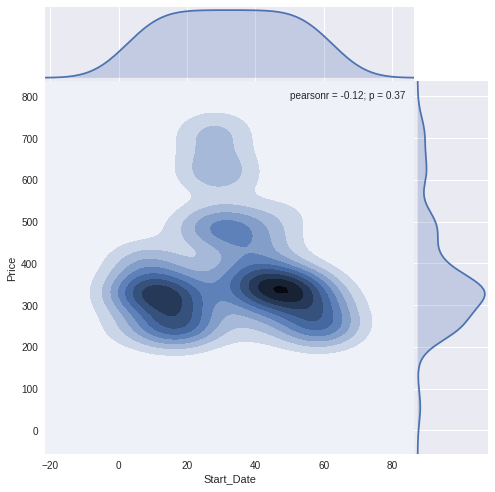

In [28]:
# Check out the gallery: 
import seaborn as sns
# this can break matplotlib for some reason...
g = sns.jointplot(df['Start_Date'], df['Price'], kind="kde", size=7, space=0)

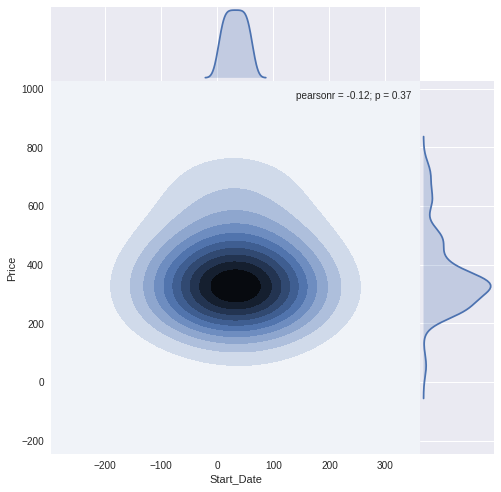

In [25]:
import seaborn as sns
# don't blindly set parameters, please read and understand what they mean and how it works
# http://seaborn.pydata.org/tutorial/distributions.html
# lots of great tutorials: http://seaborn.pydata.org/tutorial.html
g = sns.jointplot(df['Start_Date'], df['Price'], kind="kde", size=7, space=0, bw=100)

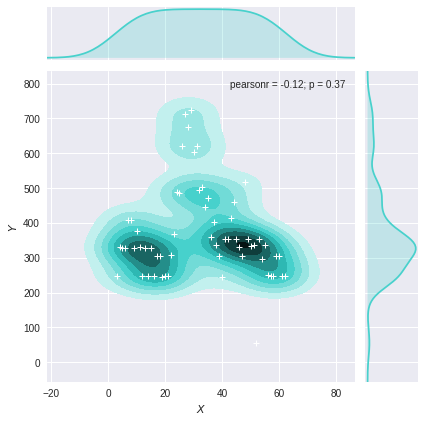

In [27]:
import matplotlib.pyplot as plt

g = sns.jointplot(x="Start_Date", y="Price", data=df, kind="kde", color="MediumTurquoise")
# https://en.wikipedia.org/wiki/Web_colors
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

In [29]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

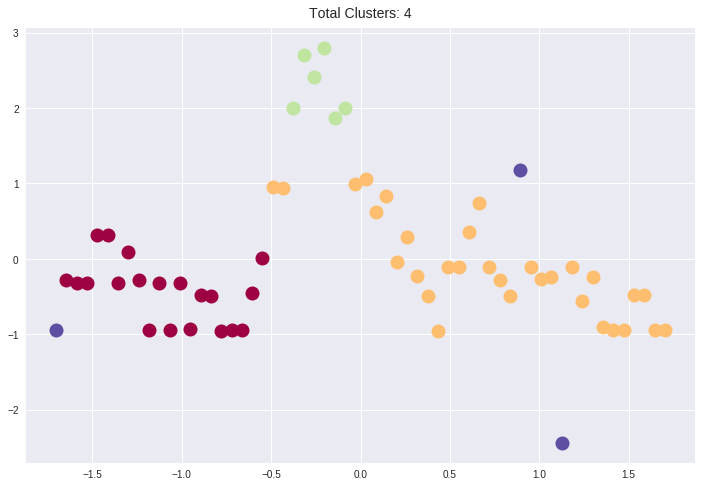

In [34]:
# All of pandas' viz is built on top of matplotlib as you might have noticed
# You can get started learning matplotlib here: http://matplotlib.org/users/pyplot_tutorial.html


# df = df.set_value(49, 'Price', 255)
X = StandardScaler().fit_transform(df[['Start_Date', 'Price']])
db = DBSCAN(eps=.5, min_samples=3).fit(X)

labels = db.labels_
clusters = len(set(labels))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
 
plt.subplots(figsize=(12,8))
 
for k, c in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=c,
            markeredgecolor='k', markersize=14)
 
plt.title("Total Clusters: {}".format(clusters), fontsize=14, y=1.01)
df['dbscan_labels'] = db.labels_

In [36]:
df.head()

,Price,Start_Date,Trip_Length,dbscan_labels
0,247.0,3,5,-1
1,332.0,4,4,0
2,327.0,5,3,0
3,327.0,6,3,0
4,408.0,7,5,0


In [37]:
df.dbscan_labels.unique()

array([-1,  0,  1,  2])

In [35]:
t = X[df.dbscan_labels == 1,:]
t.mean(axis=0)

/home/cognizac/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


array([-1.67358599, -0.59483172])

In [ ]:
df

In [ ]:
from pandas.tools.plotting import parallel_coordinates
df2 = df[['Trip_Length','Start_Date', 'Price', 'dbscan_labels']]

scaled = StandardScaler().fit_transform(df2[df2.columns[:-1]])
df2 = pd.DataFrame(scaled, columns=df2.columns[:-1])
df2['dbscan_labels'] = df.dbscan_labels

parallel_coordinates(df2, 'dbscan_labels')

In [ ]:
for result in results:
    bars = result.find_elements_by_class_name('LJTSM3-w-x')
    
    for bar in bars:
        ActionChains(driver).move_to_element(bar).perform()
        time.sleep(0.0001)
        print (result.find_element_by_class_name('LJTSM3-w-k').find_elements_by_tag_name('div')[0].text,
               result.find_element_by_class_name('LJTSM3-w-k').find_elements_by_tag_name('div')[1].text)